In [29]:
import pickle
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from utils.util import *
sns.set_theme()
sns.set_style("darkgrid")
# sns.set_context("paper")
sns.set_context("talk")

In [31]:
def font_setting():
    # Set the font dictionaries (for plot title and axis titles)
    title_font = {'fontname':'Arial', 'size':'12', 'color':'black', 'weight':'bold',
                'verticalalignment':'bottom'} # Bottom vertical alignment for more space
    axis_font = {'fontname':'Arial', 'weight': 'bold'}
    return title_font, axis_font


In [32]:
ctx_order = 'last'
ctx_order_str = 'ctxL'
analyze_name = 'analyze_regression_1D'

In [33]:
with open('../../results/%s_results_mlp.P' %(analyze_name), 'rb') as f:
    mlp_results = pickle.load(f)

with open('../../results/%s_%s_results_rnn.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnn_results = pickle.load(f)

with open('../../results/%s_%s_results_rnncell.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnncell_results = pickle.load(f)

with open('../../results/%s_results_stepwisemlp.P' %(analyze_name), 'rb') as f:
    swmlp_results = pickle.load(f)

In [34]:
mlp_runs     = dict_to_list(mlp_results, analyze_name)
rnn_runs     = dict_to_list(rnn_results, analyze_name)
rnncell_runs = dict_to_list(rnncell_results, analyze_name)
swmlp_runs   = dict_to_list(swmlp_results, analyze_name)
mlp_runs.keys()

dict_keys(['cat_reg', 'con_reg'])

In [35]:
reg_analyze_name = 'cat_reg'
mlp_cat_runs     = dict_to_list(mlp_runs, reg_analyze_name)
rnn_cat_runs     = dict_to_list(rnn_runs, reg_analyze_name)
rnncell_cat_runs = dict_to_list(rnncell_runs, reg_analyze_name)
swmlp_cat_runs   = dict_to_list(swmlp_runs, reg_analyze_name)
mlp_cat_runs.keys()

dict_keys(['p_val', 't_val', 'param', 'y_hat_E', 'y', 'bse'])

In [36]:
param_mlp = np.asarray(mlp_cat_runs['param']) # [runs, checkpoints, n_combinations]: [20, 21, 120]
p_val_mlp = np.asarray(mlp_cat_runs['p_val'])

param_rnn = np.asarray(rnn_cat_runs['param']) # [runs, checkpoints, n_combinations]: [20, 21, 120]
p_val_rnn = np.asarray(rnn_cat_runs['p_val'])

param_rnncell = np.asarray(rnncell_cat_runs['param']) # [runs, checkpoints, n_combinations]: [20, 21, 120]
p_val_rnncell = np.asarray(rnncell_cat_runs['p_val'])

param = np.asarray(swmlp_cat_runs['param']) # [runs, checkpoints, n_combinations]: [20, 21, 120]
p_val = np.asarray(swmlp_cat_runs['p_val'])

runs, checkpoints, ncoef = np.asarray(param_mlp).shape
print('runs, checkpoints, ncoef: ', runs, checkpoints, ncoef)
param_swmlp = np.zeros([runs, checkpoints, 2, ncoef])
p_val_swmlp = np.zeros([runs, checkpoints, 2, ncoef])
for r in range(runs):
    for cp in range(checkpoints):
        param_swmlp[r,cp,:,:] = param[r,cp]
        p_val_swmlp[r,cp,:,:] = p_val[r,cp]

runs, checkpoints, ncoef:  20 21 4


In [37]:
mi, mx = [], []
for coef in range(ncoef):
    mi.append(min(min(np.min(param_mlp[:,:,coef], axis=0)), 
                  min(np.min(param_rnn[:,:,coef], axis=0)),
                  min(np.min(param_rnncell[:,:,coef], axis=0)),
                  min(np.min(param_swmlp[:,:,0,coef], axis=0)),
                  min(np.min(param_swmlp[:,:,1,coef], axis=0)),))
    mx.append(max(max(np.max(param_mlp[:,:,coef], axis=0)), 
                  max(np.max(param_rnn[:,:,coef], axis=0)),
                  max(np.max(param_rnncell[:,:,coef], axis=0)),
                  max(np.max(param_swmlp[:,:,0,coef], axis=0)),
                  max(np.max(param_swmlp[:,:,1,coef], axis=0)),))

mi = min(mi) - 0.1
mx = max(mx) + 0.1
print(mi, mx)

-0.6289249888366462 2.814472353368216


# Only vanilla RNN and MLP

In [38]:
fig, axs = plt.subplots(2, ncoef, figsize=(25,10))
val_names=['Intercept', 'Ground Truth E', '1D Rank', 'Warped E']
for coef in range(ncoef):
    if coef==0:
        fig.delaxes(axs[0][coef])
        fig.delaxes(axs[1][coef])
        continue
    val_name = val_names[coef]
    # MLP
    val = param_mlp[:,:,coef]
    df = pd.DataFrame(val, columns= np.arange(checkpoints))
    df.insert(0, 'runs', np.arange(runs))
    df2 = pd.melt(df, id_vars=['runs'],var_name='steps', value_name=val_name)
    # plot
    ax = axs[0][coef]
    ax = sns.boxplot(x='steps', y=val_name, data=df2, ax=ax)
    ax = sns.stripplot(x='steps', y=val_name, data=df2, ax=ax)
    for run in range(runs):
        for i, p in enumerate(p_val_mlp[run,:,coef]):
            s = '*' if p<0.05 else ' '
            ax.annotate(s, (i, param_mlp[run, i, coef]), color='r')
    ax.set_title('MLP', fontweight='bold')
    # ax.set_ylim([-0.5, 1.5])
    # RNN
    val = param_rnn[:,:,coef]
    df = pd.DataFrame(val, columns= np.arange(checkpoints))
    df.insert(0, 'runs', np.arange(runs))
    df2 = pd.melt(df, id_vars=['runs'],var_name='steps', value_name=val_name)
    # plot
    ax = axs[1][coef]
    ax = sns.boxplot(x='steps', y=val_name, data=df2, ax=ax)
    ax = sns.stripplot(x='steps', y=val_name, data=df2, ax=ax)
    for run in range(runs):
        for i, p in enumerate(p_val_rnn[run,:,coef]):
            s = '*' if p<0.05 else ' '
            ax.annotate(s, (i, param_rnn[run, i, coef]), color='r')
    ax.set_title('RNN - Ax %s' %(ctx_order), fontweight='bold')
    # ax.set_ylim([-0.5, 1.5])
    for ax in axs.flatten():
        ax.set_ylim([mi, mx])
        ax.axhline(y=0, color='r', linewidth=2)

fig_str = '%s_reg_1D_results_both_models_hidds' %(ctx_order_str)

fig.suptitle('Regression Results - Including 1D Rank.', fontweight='bold')
plt.tight_layout()
fig.savefig(('../../figures/' + fig_str + '.pdf'), 
            bbox_inches = 'tight', pad_inches = 0)
fig.savefig(('../../figures/' + fig_str + '.png'), 
            bbox_inches = 'tight', pad_inches = 0)


# Including stepwise MLP

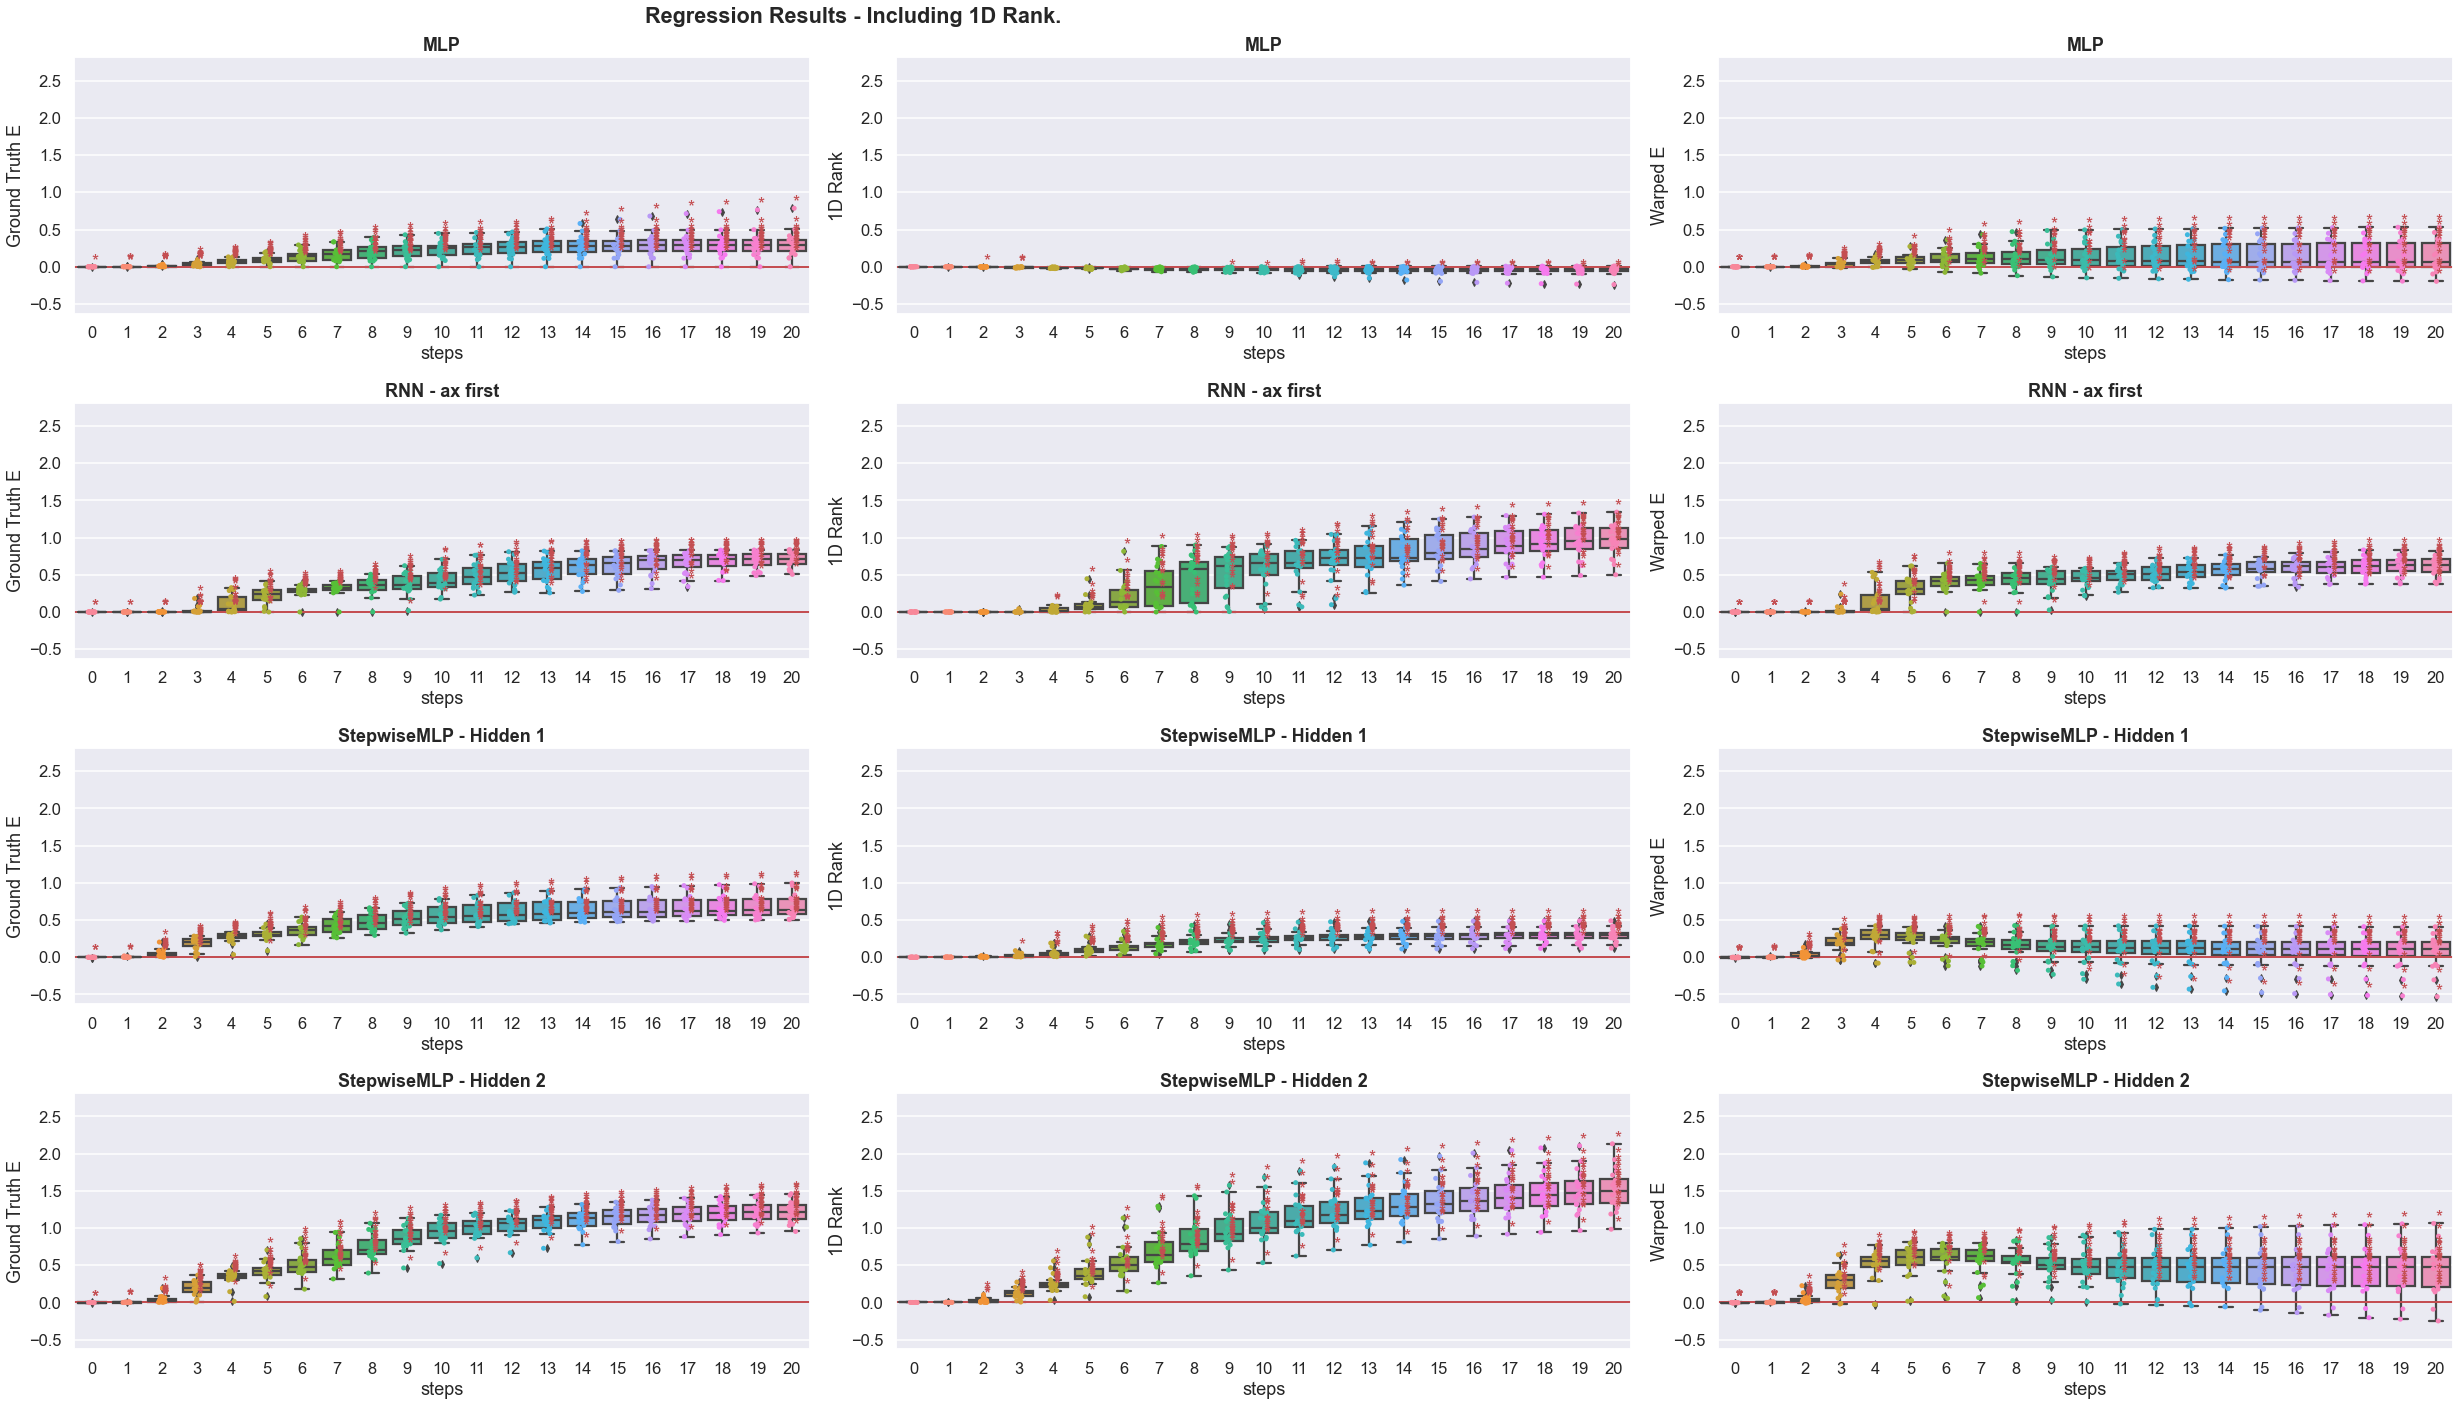

In [ ]:
fig, axs = plt.subplots(4, ncoef, figsize=(45,20))
val_names = ['Intercept', 'Ground Truth E', '1D Rank', 'Warped E']
for coef in range(ncoef):
    if coef == 0:
        fig.delaxes(axs[0][coef])
        fig.delaxes(axs[1][coef])
        fig.delaxes(axs[2][coef])
        fig.delaxes(axs[3][coef])
        continue
    val_name = val_names[coef]
    # MLP
    val = param_mlp[:,:,coef]
    df = pd.DataFrame(val, columns= np.arange(checkpoints))
    df.insert(0, 'runs', np.arange(runs))
    df2 = pd.melt(df, id_vars=['runs'],var_name='steps', value_name=val_name)
    # plot
    ax = axs[0][coef]
    ax = sns.boxplot(x='steps', y=val_name, data=df2, ax=ax)
    ax = sns.stripplot(x='steps', y=val_name, data=df2, ax=ax)
    for run in range(runs):
        for i, p in enumerate(p_val_mlp[run,:,coef]):
            s = '*' if p<0.05 else ' '
            ax.annotate(s, (i, param_mlp[run, i, coef]), color='r')
    ax.set_title('MLP', fontweight='bold')
    # RNN
    val = param_rnn[:,:,coef]
    df = pd.DataFrame(val, columns= np.arange(checkpoints))
    df.insert(0, 'runs', np.arange(runs))
    df2 = pd.melt(df, id_vars=['runs'],var_name='steps', value_name=val_name)
    # plot
    ax = axs[1][coef]
    ax = sns.boxplot(x='steps', y=val_name, data=df2, ax=ax)
    ax = sns.stripplot(x='steps', y=val_name, data=df2, ax=ax)
    for run in range(runs):
        for i, p in enumerate(p_val_rnn[run,:,coef]):
            s = '*' if p<0.05 else ' '
            ax.annotate(s, (i, param_rnn[run, i, coef]), color='r')
    ax.set_title('RNN - ax %s' %(ctx_order), fontweight='bold')
    # Stepwise MLP - Hidden 1
    val = param_swmlp[:,:,0,coef]
    df = pd.DataFrame(val, columns= np.arange(checkpoints))
    df.insert(0, 'runs', np.arange(runs))
    df2 = pd.melt(df, id_vars=['runs'],var_name='steps', value_name=val_name)
    # plot
    ax = axs[2][coef]
    ax = sns.boxplot(x='steps', y=val_name, data=df2, ax=ax)
    ax = sns.stripplot(x='steps', y=val_name, data=df2, ax=ax)
    for run in range(runs):
        for i, p in enumerate(p_val_swmlp[run,:,0,coef]):
            s = '*' if p<0.05 else ' '
            ax.annotate(s, (i, param_swmlp[run,i,0,coef]), color='r')
    ax.set_title('StepwiseMLP - Hidden 1', fontweight='bold')
    # Stepwise MLP - Hidden 2
    val = param_swmlp[:,:,1,coef]
    df = pd.DataFrame(val, columns= np.arange(checkpoints))
    df.insert(0, 'runs', np.arange(runs))
    df2 = pd.melt(df, id_vars=['runs'],var_name='steps', value_name=val_name)
    # plot
    ax = axs[3][coef]
    ax = sns.boxplot(x='steps', y=val_name, data=df2, ax=ax)
    ax = sns.stripplot(x='steps', y=val_name, data=df2, ax=ax)
    for run in range(runs):
        for i, p in enumerate(p_val_swmlp[run,:,1,coef]):
            s = '*' if p<0.05 else ' '
            ax.annotate(s, (i, param_swmlp[run,i,1,coef]), color='r')
    ax.set_title('StepwiseMLP - Hidden 2', fontweight='bold')
for ax in axs.flatten():
    ax.set_ylim([mi, mx])
    ax.axhline(y=0, color='r', linewidth=2)

fig_str = '%s_reg_1D_results_three_models_hidds' %(ctx_order_str)
fig.suptitle('Regression Results - Including 1D Rank.', fontweight='bold')
plt.tight_layout()
plt.show()
fig.savefig(('../../figures/' + fig_str + '.pdf'), 
            bbox_inches = 'tight', pad_inches = 0)
fig.savefig(('../../figures/' + fig_str + '.png'), 
            bbox_inches = 'tight', pad_inches = 0)


# Truncated backprop - RNNCell

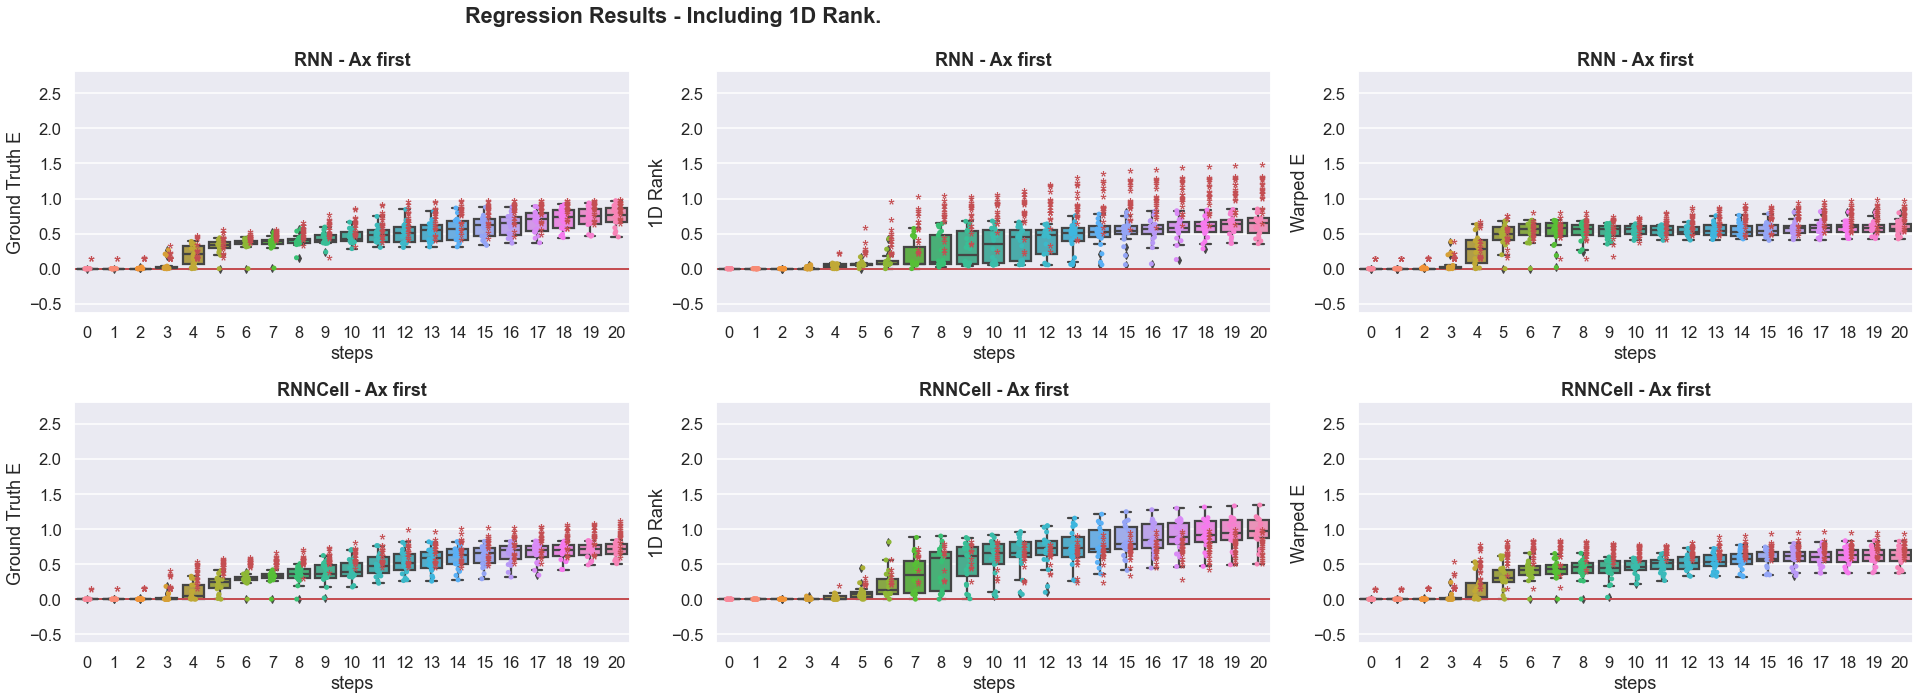

In [ ]:
fig, axs = plt.subplots(2, ncoef, figsize=(35,10))
val_names=['Intercept', 'Ground Truth E', '1D Rank', 'Warped E']
for coef in range(ncoef):
    if coef==0:
        fig.delaxes(axs[0][coef])
        fig.delaxes(axs[1][coef])
        continue
    val_name = val_names[coef]
    # RNN
    val = param_rnncell[:,:,coef]
    df = pd.DataFrame(val, columns= np.arange(checkpoints))
    df.insert(0, 'runs', np.arange(runs))
    df2 = pd.melt(df, id_vars=['runs'],var_name='steps', value_name=val_name)
    # plot
    ax = axs[0][coef]
    ax = sns.boxplot(x='steps', y=val_name, data=df2, ax=ax)
    ax = sns.stripplot(x='steps', y=val_name, data=df2, ax=ax)
    for run in range(runs):
        for i, p in enumerate(p_val_rnn[run,:,coef]):
            s = '*' if p<0.05 else ' '
            ax.annotate(s, (i, param_rnn[run, i, coef]), color='r')
    ax.set_title('RNN - Ax %s' %(ctx_order), fontweight='bold')
    
    # RNN Cell
    val = param_rnn[:,:,coef]
    df = pd.DataFrame(val, columns= np.arange(checkpoints))
    df.insert(0, 'runs', np.arange(runs))
    df2 = pd.melt(df, id_vars=['runs'],var_name='steps', value_name=val_name)
    # plot
    ax = axs[1][coef]
    ax = sns.boxplot(x='steps', y=val_name, data=df2, ax=ax)
    ax = sns.stripplot(x='steps', y=val_name, data=df2, ax=ax)
    for run in range(runs):
        for i, p in enumerate(p_val_rnncell[run,:,coef]):
            s = '*' if p<0.05 else ' '
            ax.annotate(s, (i, param_rnncell[run, i, coef]), color='r')
    ax.set_title('RNNCell - Ax %s' %(ctx_order), fontweight='bold')
    
    for ax in axs.flatten():
        ax.set_ylim([mi, mx])
        ax.axhline(y=0, color='r', linewidth=2)

fig_str = '%s_reg_1D_results_both_rnnmodels_hidds' %(ctx_order_str)

fig.suptitle('Regression Results - Including 1D Rank.', fontweight='bold')
plt.tight_layout()
fig.savefig(('../../figures/' + fig_str + '.pdf'), 
            bbox_inches = 'tight', pad_inches = 0)
fig.savefig(('../../figures/' + fig_str + '.png'), 
            bbox_inches = 'tight', pad_inches = 0)
